##### Copyright 2022 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [6]:
#@title Copyright 2022 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Frame interpolation using the FILM model


Frame interpolation is the task of synthesizing many in-between images from a given set of images. The technique is often used for frame rate upsampling or creating slow-motion video effects.

In this colab, you will use the FILM model to do frame interpolation. The colab also provides code snippets to create videos from the interpolated in-between images.

For more information on FILM research, you can read more here:
- Google AI Blog: [Large Motion Frame Interpolation](https://ai.googleblog.com/2022/10/large-motion-frame-interpolation.html)
- Project Page: FILM: [Frame Interpolation for Large Motion](https://film-net.github.io/)


## Setup

In [7]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
import numpy as np

from typing import Generator, Iterable, List, Optional
import mediapy as media

## Load the model from TFHub

To load a model from TensorFlow Hub you need the tfhub library and the model handle which is its documentation url.

In [8]:
model = hub.load("https://tfhub.dev/google/film/1")

## Util function to load images from a url or locally

This function loads an image and make it ready to be used by the model later.

In [9]:
_UINT8_MAX_F = float(np.iinfo(np.uint8).max)

def load_image(img_url: str):
  """Returns an image with shape [height, width, num_channels], with pixels in [0..1] range, and type np.float32."""

  if (img_url.startswith("https")):
    user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
    response = requests.get(img_url, headers=user_agent)
    image_data = response.content
  else:
    image_data = tf.io.read_file(img_url)

  image = tf.io.decode_image(image_data, channels=3)
  image_numpy = tf.cast(image, dtype=tf.float32).numpy()
  return image_numpy / _UINT8_MAX_F


FILM's model input is a dictionary with the keys `time`, `x0`, `x1`:

- `time`: position of the interpolated frame. Midway is `0.5`.
- `x0`: is the initial frame.
- `x1`: is the final frame.

Both frames need to be normalized (done in the function `load_image` above) where each pixel is in the range of `[0..1]`.

`time` is a value between `[0..1]` and it says where the generated image should be. 0.5 is midway between the input images.

All three values need to have a batch dimension too.

In [10]:
# using images from the FILM repository (https://github.com/google-research/frame-interpolation/)

image_1_url = "../compress/frames/0000.jpg"
image_2_url = "../compress/frames/0016.jpg"

time = np.array([0.5], dtype=np.float32)

image1 = load_image(image_1_url)
image2 = load_image(image_2_url)

In [11]:
input = {
    'time': np.expand_dims(time, axis=0), # adding the batch dimension to the time
     'x0': np.expand_dims(image1, axis=0), # adding the batch dimension to the image
     'x1': np.expand_dims(image2, axis=0)  # adding the batch dimension to the image
}
mid_frame = model(input)

The model outputs a couple of results but what you'll use here is the `image` key, whose value is the interpolated frame.

In [12]:
print(mid_frame.keys())

dict_keys(['image', 'x0_warped', 'x1_warped', 'forward_residual_flow_pyramid', 'forward_flow_pyramid', 'backward_residual_flow_pyramid', 'backward_flow_pyramid'])


input image one,generated image,input image two

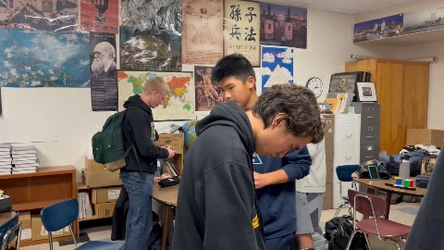
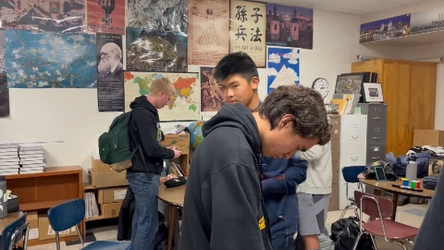
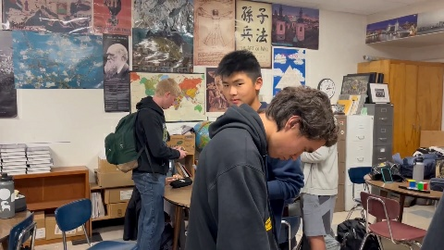

In [13]:
frames = [image1, mid_frame['image'][0].numpy(), image2]

media.show_images(frames, titles=['input image one', 'generated image', 'input image two'], height=250)

Let's create a video from the generated frames

In [14]:
media.show_video(frames, fps=3, title='FILM interpolated video')

## Define a Frame Interpolator Library

As you can see, the transition is not too smooth. 

To improve that you'll need many more interpolated frames.

You could just keep running the model many times with intermediary images but there is a better solution.

To generate many interpolated images and have a  smoother video you'll create an interpolator library.

In [15]:
"""A wrapper class for running a frame interpolation based on the FILM model on TFHub

Usage:
  interpolator = Interpolator()
  result_batch = interpolator(image_batch_0, image_batch_1, batch_dt)
  Where image_batch_1 and image_batch_2 are numpy tensors with TF standard
  (B,H,W,C) layout, batch_dt is the sub-frame time in range [0..1], (B,) layout.
"""


def _pad_to_align(x, align):
  """Pads image batch x so width and height divide by align.

  Args:
    x: Image batch to align.
    align: Number to align to.

  Returns:
    1) An image padded so width % align == 0 and height % align == 0.
    2) A bounding box that can be fed readily to tf.image.crop_to_bounding_box
      to undo the padding.
  """
  # Input checking.
  assert np.ndim(x) == 4
  assert align > 0, 'align must be a positive number.'

  height, width = x.shape[-3:-1]
  height_to_pad = (align - height % align) if height % align != 0 else 0
  width_to_pad = (align - width % align) if width % align != 0 else 0

  bbox_to_pad = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height + height_to_pad,
      'target_width': width + width_to_pad
  }
  padded_x = tf.image.pad_to_bounding_box(x, **bbox_to_pad)
  bbox_to_crop = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height,
      'target_width': width
  }
  return padded_x, bbox_to_crop


class Interpolator:
  """A class for generating interpolated frames between two input frames.

  Uses the Film model from TFHub
  """

  def __init__(self, align: int = 64) -> None:
    """Loads a saved model.

    Args:
      align: 'If >1, pad the input size so it divides with this before
        inference.'
    """
    self._model = hub.load("https://tfhub.dev/google/film/1")
    self._align = align

  def __call__(self, x0: np.ndarray, x1: np.ndarray,
               dt: np.ndarray) -> np.ndarray:
    """Generates an interpolated frame between given two batches of frames.

    All inputs should be np.float32 datatype.

    Args:
      x0: First image batch. Dimensions: (batch_size, height, width, channels)
      x1: Second image batch. Dimensions: (batch_size, height, width, channels)
      dt: Sub-frame time. Range [0,1]. Dimensions: (batch_size,)

    Returns:
      The result with dimensions (batch_size, height, width, channels).
    """
    if self._align is not None:
      x0, bbox_to_crop = _pad_to_align(x0, self._align)
      x1, _ = _pad_to_align(x1, self._align)

    inputs = {'x0': x0, 'x1': x1, 'time': dt[..., np.newaxis]}
    result = self._model(inputs, training=False)
    image = result['image']

    if self._align is not None:
      image = tf.image.crop_to_bounding_box(image, **bbox_to_crop)
    return image.numpy()

## Frame and Video Generation Utility Functions

In [16]:
def _recursive_generator(
    frame1: np.ndarray, frame2: np.ndarray, num_recursions: int,
    interpolator: Interpolator) -> Generator[np.ndarray, None, None]:
  """Splits halfway to repeatedly generate more frames.

  Args:
    frame1: Input image 1.
    frame2: Input image 2.
    num_recursions: How many times to interpolate the consecutive image pairs.
    interpolator: The frame interpolator instance.

  Yields:
    The interpolated frames, including the first frame (frame1), but excluding
    the final frame2.
  """
  if num_recursions == 0:
    yield frame1
  else:
    # Adds the batch dimension to all inputs before calling the interpolator,
    # and remove it afterwards.
    time = np.full(shape=(1,), fill_value=0.5, dtype=np.float32)
    mid_frame = interpolator(
        np.expand_dims(frame1, axis=0), np.expand_dims(frame2, axis=0), time)[0]
    yield from _recursive_generator(frame1, mid_frame, num_recursions - 1,
                                    interpolator)
    yield from _recursive_generator(mid_frame, frame2, num_recursions - 1,
                                    interpolator)


def interpolate_recursively(
    frames: List[np.ndarray], num_recursions: int,
    interpolator: Interpolator) -> Iterable[np.ndarray]:
  """Generates interpolated frames by repeatedly interpolating the midpoint.

  Args:
    frames: List of input frames. Expected shape (H, W, 3). The colors should be
      in the range[0, 1] and in gamma space.
    num_recursions: Number of times to do recursive midpoint
      interpolation.
    interpolator: The frame interpolation model to use.

  Yields:
    The interpolated frames (including the inputs).
  """
  n = len(frames)
  for i in range(1, n):
    yield from _recursive_generator(frames[i - 1], frames[i],
                                    times_to_interpolate, interpolator)
  # Separately yield the final frame.
  yield frames[-1]

In [17]:
times_to_interpolate = 6
interpolator = Interpolator()

## Running the Interpolator

In [18]:
input_frames = [image1, image2]
frames = list(
    interpolate_recursively(input_frames, times_to_interpolate,
                                        interpolator))


In [19]:
print(f'video with {len(frames)} frames')
media.show_video(frames, fps=30, title='FILM interpolated video')

video with 65 frames


For more information, you can visit [FILM's model repository](https://github.com/google-research/frame-interpolation).


## Citation

If you find this model and code useful in your works, please acknowledge it appropriately by citing:

```
@inproceedings{reda2022film,
 title = {FILM: Frame Interpolation for Large Motion},
 author = {Fitsum Reda and Janne Kontkanen and Eric Tabellion and Deqing Sun and Caroline Pantofaru and Brian Curless},
 booktitle = {The European Conference on Computer Vision (ECCV)},
 year = {2022}
}
```

```
@misc{film-tf,
  title = {Tensorflow 2 Implementation of "FILM: Frame Interpolation for Large Motion"},
  author = {Fitsum Reda and Janne Kontkanen and Eric Tabellion and Deqing Sun and Caroline Pantofaru and Brian Curless},
  year = {2022},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished = {\url{https://github.com/google-research/frame-interpolation}}
}
```